## Load Data, Get Representation, Train Binary Classification RNN Model
(Binary classification on log fold change)

In [1]:
%load_ext autoreload
%autoreload 2


import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras

/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the pre-trained model

In [2]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")

In [3]:
R3_lib['Length'] = [len(seq) for seq in R3_lib['Peptide']]
R3_lib_seq9 = R3_lib.loc[(R3_lib['Length'] == 9)].copy()

In [4]:
protein_of_interest = "MDM2"
other_protein = "12ca5"
(
    X,
    mdm2_y,
    mdm2_y_raw,
    ca5_y,
    ca5_y_raw,
    peptides,
    FEATURE_LIST,
) = data_loading.build_dataset(
    R3_lib_seq9,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    aa_representations=[
        data_loading.AA_REPRESENTATION.PRO2VEC,
        data_loading.AA_REPRESENTATION.RAA,
        data_loading.AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
    ],
)

# (
#     X_train,
#     X_test,
#     mdm2_y_train,
#     mdm2_y_test,
#     mdm2_y_raw_train,
#     mdm2_y_raw_test,
#     ca5_y_train,
#     ca5_y_test,
#     ca5_y_raw_train,
#     ca5_y_raw_test,
#     peptides_train,
#     peptides_test,
# ) = train_test_split(
#     X,
#     mdm2_y,
#     mdm2_y_raw,
#     ca5_y,
#     ca5_y_raw,
#     peptides,
#     test_size=0.2,
#     shuffle=True,
#     random_state=5,
# )




 - log P value cutoff is -0.5486114099865677, and log FC value cutoff is -0.5635823330227997


In [5]:
X=X[:,:9,:]

In [6]:

mdm2_model = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X,
    mdm2_y,
    rnn.Joint_BinaryClassificationRNN_gelu
)
# mdm2_y_pred_raw = mdm2_model(X_test)
# mdm2_y_pred = mdm2_y_pred_raw > 0.5

# print("MDM2")
# evaluation.classification_evaluation_joint(mdm2_y_test, mdm2_y_pred)



# result = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
#     X, y, rnn.Joint_BinaryClassificationRNN_gelu
# )


2023-02-08 19:50:27.292108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
126/126 [==============================] - 4s 11ms/step - loss: 0.5975 - accuracy: 0.3786 - recall: 0.9632 - precision: 0.7272 - val_loss: 0.5617 - val_accuracy: 0.3367 - val_recall: 1.0000 - val_precision: 0.7354
Epoch 2/50
126/126 [==============================] - 1s 5ms/step - loss: 0.5619 - accuracy: 0.3734 - recall: 0.9979 - precision: 0.7321 - val_loss: 0.5470 - val_accuracy: 0.3861 - val_recall: 0.9908 - val_precision: 0.7465
Epoch 3/50
126/126 [==============================] - 1s 5ms/step - loss: 0.5471 - accuracy: 0.4057 - recall: 0.9904 - precision: 0.7441 - val_loss: 0.5394 - val_accuracy: 0.3962 - val_recall: 0.9855 - val_precision: 0.7524
Epoch 4/50
126/126 [==============================] - 1s 5ms/step - loss: 0.5374 - accuracy: 0.4014 - recall: 0.9915 - precision: 0.7466 - val_loss: 0.5487 - val_accuracy: 0.4287 - val_recall: 0.9649 - val_precision: 0.7536
Epoch 5/50
126/126 [==============================] - 1s 4ms/step - loss: 0.5310 - accuracy: 0.4010 - r

In [7]:
# compute 12ca5 preditions by reversing MDM2 FC preditions
ca5_y_pred_raw_derived_from_mdm2 = np.copy(mdm2_y_pred_raw)
ca5_y_pred_raw_derived_from_mdm2[:, 1] = 1-ca5_y_pred_raw_derived_from_mdm2[:,1]
ca5_y_pred_derived_from_mdm2 = ca5_y_pred_raw_derived_from_mdm2 > 0.5

print('\n12ca5 Derived from inverted MDM2 Model Output')
# evaluate accuracy, precision, recall of trianed model
evaluation.classification_evaluation_joint(ca5_y_test, ca5_y_pred_derived_from_mdm2)


NameError: name 'mdm2_y_pred_raw' is not defined

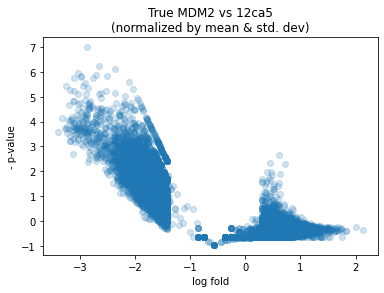

In [7]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], alpha=0.2)
    plt.show()

show_volcano(
    mdm2_y_raw, protein_of_interest, other_protein, title_addendum="True "
)

## UMAPs!

In [8]:
X.shape

(22264, 9, 16)

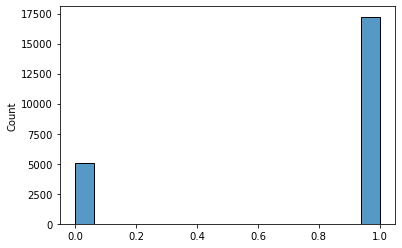

In [9]:
g=sns.histplot(mdm2_y[:,1])

In [10]:
mdm2_model = mdm2_model.trained_model

In [11]:
mdm2_model.save("my_model_seq9")

INFO:tensorflow:Assets written to: my_model_seq9/assets


INFO:tensorflow:Assets written to: my_model_seq9/assets


In [12]:
embedding=umap.embedding_classification(mdm2_model,X)

The size we are going with for MDM2 hotspot 1346
The size we are going with for 12ca5 hotspot 1981


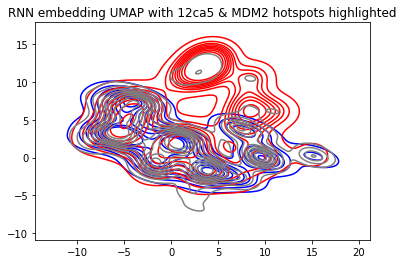

In [13]:
umap.UMAP_dual_vis(embedding, mdm2_y_raw,kde=True)

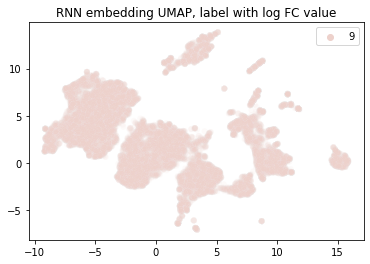

In [14]:
umap.UMAP_log_Fold(embedding, [len(RAA_to_seq(item)) for item in X[:,:,1]])

The size we are going with for MDM2 hotspot 1346
The size we are going with for 12ca5 hotspot 1981


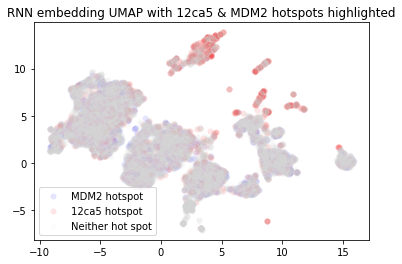

In [15]:
umap.UMAP_dual_vis(embedding, mdm2_y_raw)

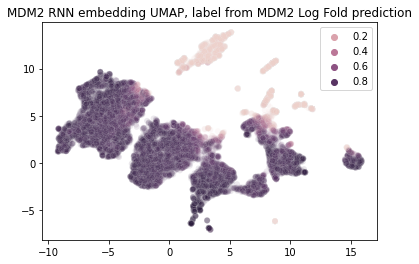

In [16]:
umap.UMAP_vis(
    embedding,
    mdm2_model(X)[:, 1],
    title="MDM2 RNN embedding UMAP, label from MDM2 Log Fold prediction",
)

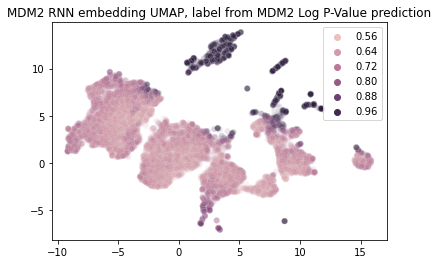

In [17]:
umap.UMAP_vis(
    embedding,
    mdm2_model(X)[:, 0],
    title="MDM2 RNN embedding UMAP, label from MDM2 Log P-Value prediction",
)

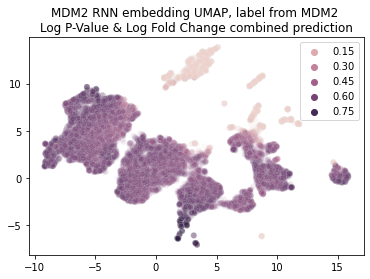

In [18]:
umap.UMAP_vis(
    embedding,
    mdm2_model(X)[:, 0] * mdm2_model(X)[:, 1],
    title="MDM2 RNN embedding UMAP, label from MDM2 \nLog P-Value & Log Fold Change combined prediction",
)

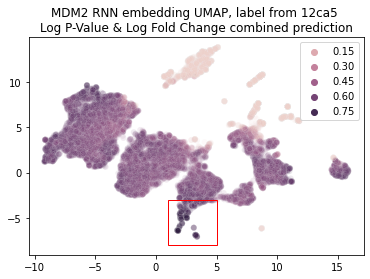

In [24]:
import matplotlib
rect = matplotlib.patches.Rectangle(
    (1, -8), 4, 5, linewidth=1, edgecolor="r", facecolor="none"
)
umap.UMAP_vis(
    embedding,
    mdm2_model(X)[:, 0] * mdm2_model(X)[:, 1],
    title="MDM2 RNN embedding UMAP, label from 12ca5 \nLog P-Value & Log Fold Change combined prediction",
    rectangle=rect
)

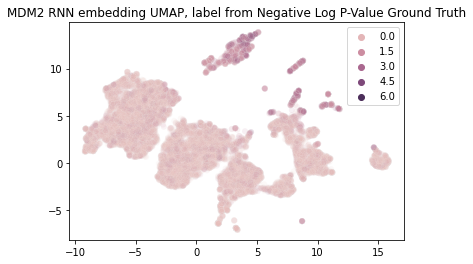

In [25]:
umap.UMAP_vis(
    embedding,
    mdm2_y_raw[:, 0],
    title="MDM2 RNN embedding UMAP, label from Negative Log P-Value Ground Truth",
)

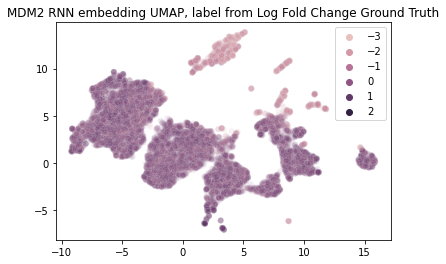

In [26]:
umap.UMAP_vis(
    embedding,
    mdm2_y_raw[:, 1],
    title="MDM2 RNN embedding UMAP, label from Log Fold Change Ground Truth",
)

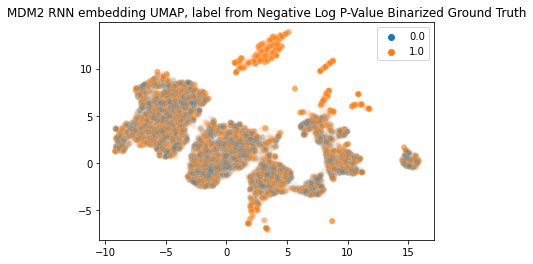

In [27]:
umap.UMAP_vis(
    embedding,
    mdm2_y[:, 0],
    title="MDM2 RNN embedding UMAP, label from Negative Log P-Value Binarized Ground Truth",
)

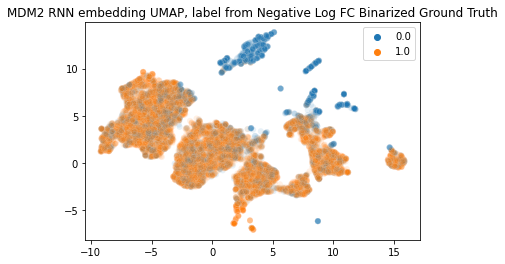

In [28]:
umap.UMAP_vis(
    embedding,
    mdm2_y[:, 1],
    title="MDM2 RNN embedding UMAP, label from Negative Log FC Binarized Ground Truth",
)

Text(0.5, 0, 'log_P value')

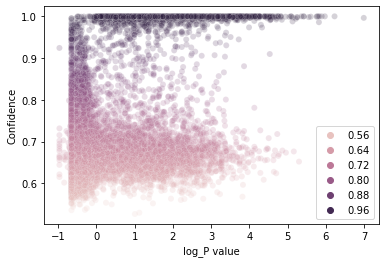

In [29]:
# confidence analysis
ax = sns.scatterplot(x=mdm2_y_raw[:,0], y=mdm2_model(X)[:,0].numpy().reshape(-1), hue=mdm2_model(X)[:,0].numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('log_P value')

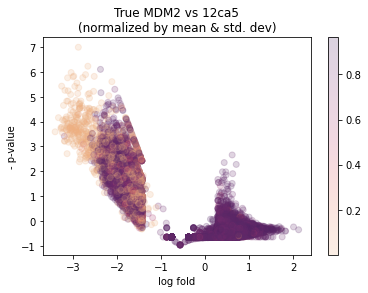

In [30]:
import matplotlib.pyplot as plt

## log Fold change 

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], c = mdm2_model(X)[:,1], alpha=0.2, cmap='flare')
    plt.colorbar()
    plt.show()

show_volcano(
    mdm2_y_raw, protein_of_interest, other_protein, title_addendum="True "
)

In [32]:
hits_mdm2 = []
for i in range(len(X)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if 1<x1<5 and -8<x2<-3:
        hits_mdm2.append(1)
    else:
        hits_mdm2.append(0)

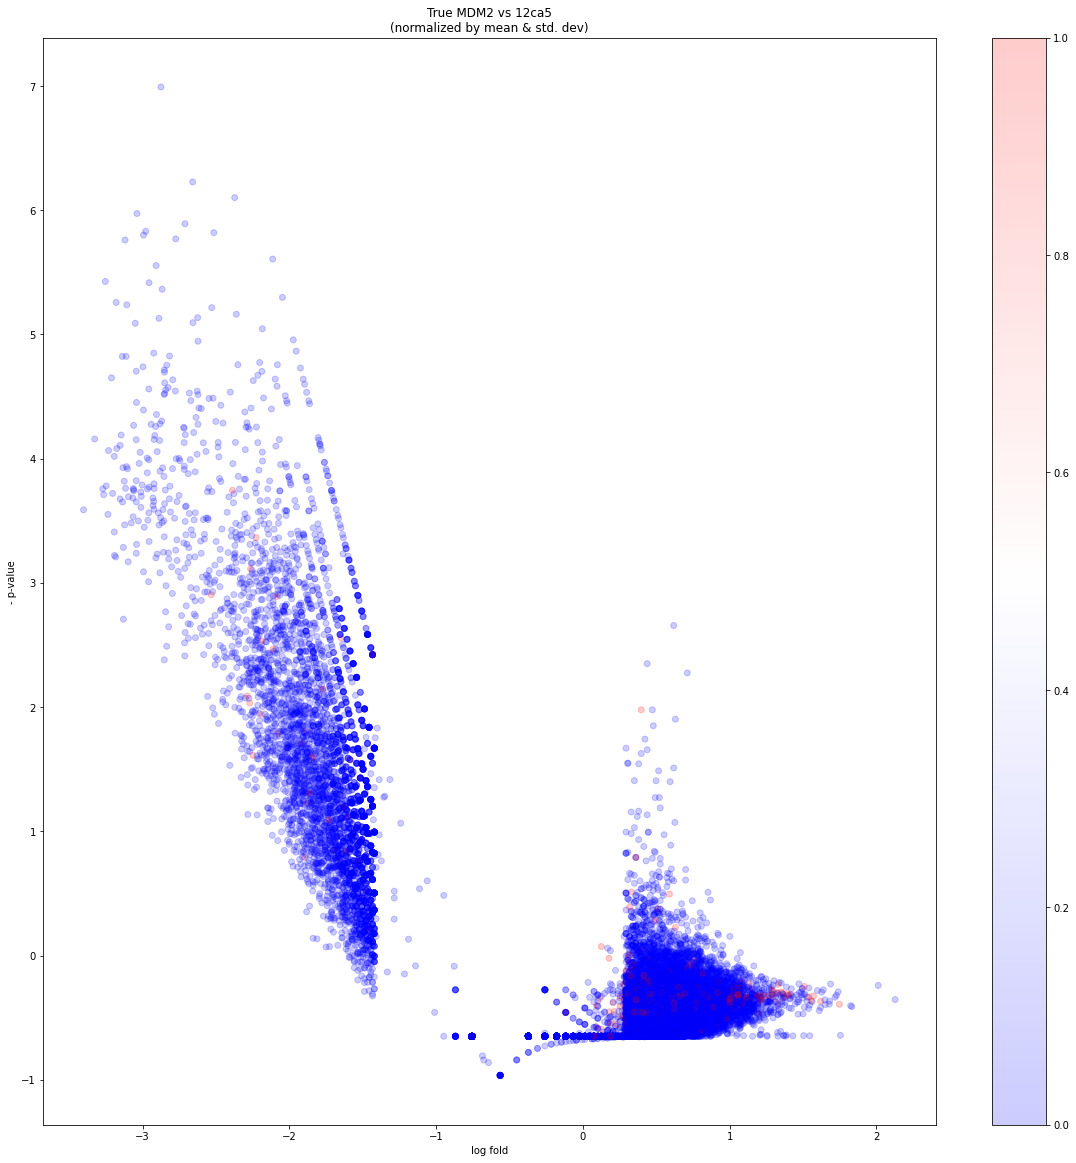

In [33]:
def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.figure(figsize=(20,20))
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], c = hits_mdm2, alpha=0.2, cmap='bwr')
    plt.colorbar()
    plt.show()
    
show_volcano(
    mdm2_y_raw, protein_of_interest, other_protein, title_addendum="True "
)

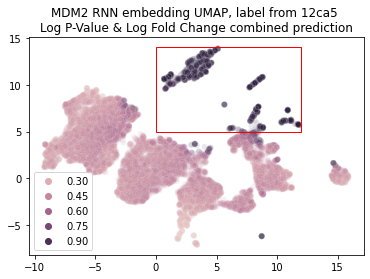

In [36]:
ca5_coordinate = (0, 5)
ca5_width, ca5_height = 12, 9
ca5_rect = matplotlib.patches.Rectangle(
    ca5_coordinate, ca5_width, ca5_height, linewidth=1, edgecolor="r", facecolor="none"
)

umap.UMAP_vis(
    embedding,
    1-mdm2_model(X)[:, 0] * mdm2_model(X)[:, 1],
    title="MDM2 RNN embedding UMAP, label from 12ca5 \nLog P-Value & Log Fold Change combined prediction",
    rectangle=ca5_rect,
)


In [66]:
hits_12ca5 = []
for i in range(len(X)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if 0<x1<3 and 5<x2<14:
        hits_12ca5.append(1)
    else:
        hits_12ca5.append(0)

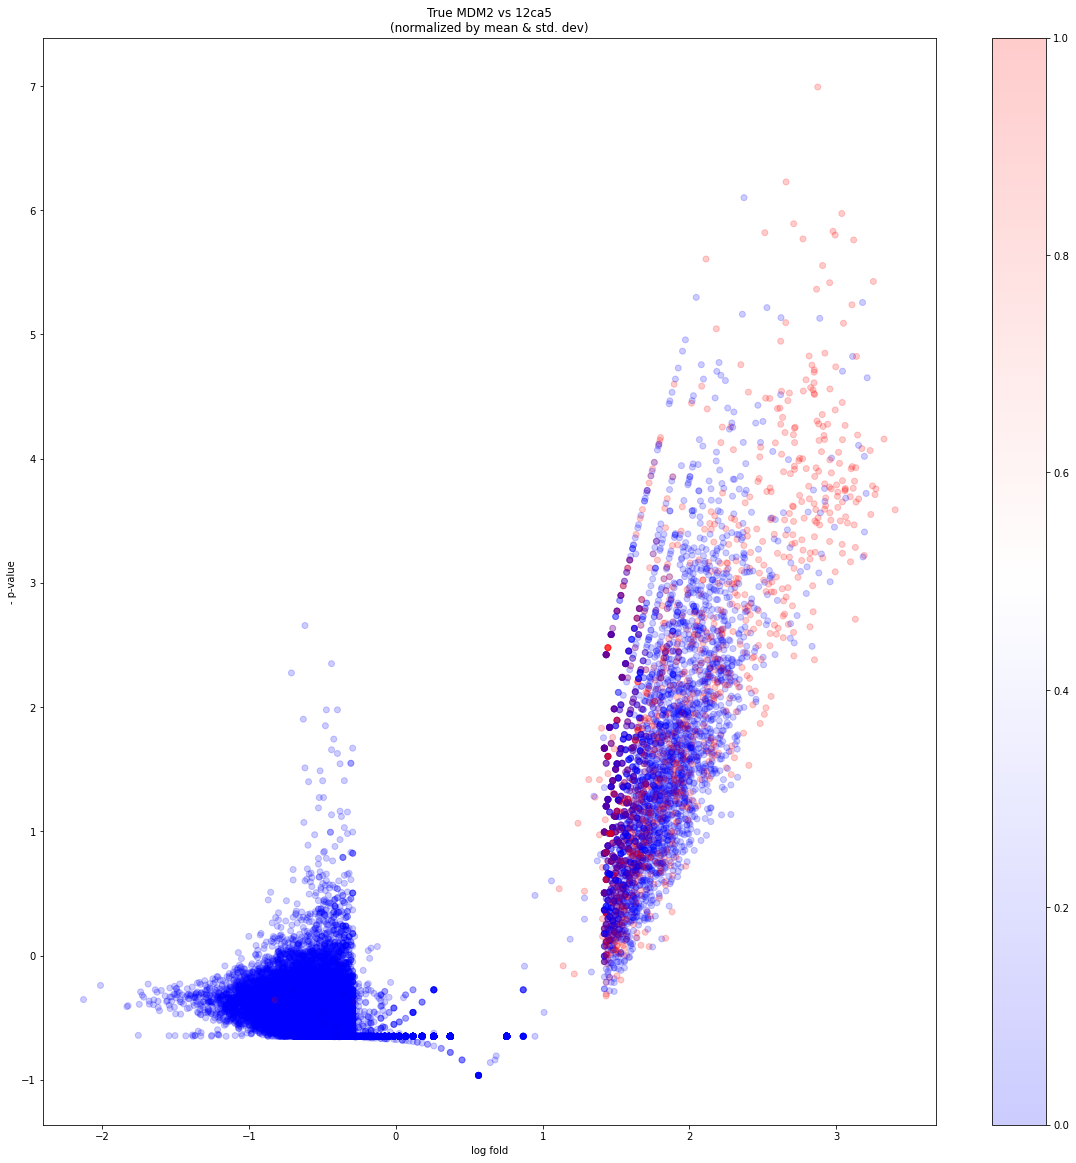

In [70]:
def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.figure(figsize=(20,20))
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(-y[:, 1], y[:, 0], c = hits_12ca5, alpha=0.2, cmap='bwr')
    plt.colorbar()
    plt.show()
    
show_volcano(
    mdm2_y_raw, protein_of_interest, other_protein, title_addendum="True "
)